# Imports

In [2]:
import webdriver_manager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.chrome.service import Service as ChromeService
from IPython.display import clear_output
import time
import pandas as pd
import IPython
import os
import re
import tqdm

# Driver and Functions

In [36]:
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))

In [4]:
def login():
    driver.get("https://ocs.iitd.ac.in/portal/login")
    ID = "phs217181"
    # password = input("Enter your password: ")
    password = "ef436a14"
    driver.get("https://ocs.iitd.ac.in/portal/login")
    driver.find_element(By.ID, "mat-input-0").send_keys(ID)
    driver.find_element(By.ID, "mat-input-1").send_keys(password)
    captcha = driver.find_element(By.TAG_NAME, "object")
    captcha.screenshot("captcha.png")
    IPython.display.display(IPython.display.Image("captcha.png"))
    captcha_code = input("Enter the captcha code: ")
    driver.find_element(By.ID, "mat-input-2").send_keys(captcha_code)
    driver.find_element(By.TAG_NAME, "button").click()

In [8]:
def list_companies(url = "https://ocs.iitd.ac.in/portal/student/applications", class1= "mat-select-value-5", class2 = "mat-option-14"):
    driver.get(url)
    driver.find_element(By.ID, class1).click()
    driver.find_element(By.ID, class2).click()
    max_rows = int(driver.find_element(By.CLASS_NAME, "mat-paginator-range-label").text.split(" ")[-1])
    return max_rows

In [ ]:
def result(max_rows):
    companies = []
    profiles = []
    page_num = 0
    per_page = 50
    while page_num*per_page<=max_rows:
        print(f"Currently on page {page_num+1}", end="\r")
        table = driver.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        for i in range(1, len(rows)):
            data = rows[i].find_element(By.TAG_NAME, "td").text.split("\n")[0]
            company = data.split("(")[0]
            profile = data.split("(")[1].split(")")[0]
            companies.append(company.strip())
            profiles.append(profile.strip())
        next_btn = driver.find_elements(By.CLASS_NAME, "mat-button-wrapper")[1]
        next_btn.click()
        page_num+=1
    all_companies = pd.DataFrame([companies, profiles]).T
    all_companies.columns = ["Company", "Profile"]
    return all_companies

In [55]:
def logout():
    for item in driver.find_elements(By.TAG_NAME ,"mat-icon"):
        if item.text == "exit_to_app":
            item.click()
            return None

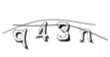

In [37]:
login()

In [40]:
max_rows = list_companies()

In [47]:
table = driver.find_element(By.TAG_NAME, "table")
rows = table.find_elements(By.TAG_NAME, "tr")

In [51]:
rows[1].find_elements(By.TAG_NAME, "td")[0].text

'Godrej Capital (Assistant Manager - Analytics)'

In [52]:
def get_positions():
    positions = []
    titles = []
    page_num = 0
    per_page = 50
    while page_num*per_page<=max_rows:
        print(f"Currently on page {page_num+1}", end="\r")
        table = driver.find_element(By.TAG_NAME, "table")
        rows = table.find_elements(By.TAG_NAME, "tr")
        for i in tqdm.tqdm(range(1, len(rows)), desc="Getting positions"):
            title = rows[i].find_elements(By.TAG_NAME, "td")[0].text
            titles.append(title)
            rows[i].find_elements(By.TAG_NAME, "td")[0].click()
            driver.switch_to.window(driver.window_handles[-1])
            time.sleep(2)
            source = driver.page_source
            idx = source.find("No. of Offers:")
            regex = re.compile(r">(\d+)")
            res = regex.findall(source[idx:idx+100])
            if res:
                positions.append(int(res[0]))
            else:
                positions.append(None)
            driver.close()
            driver.switch_to.window(driver.window_handles[0])
        next_btn = driver.find_elements(By.CLASS_NAME, "mat-button-wrapper")[1]
        next_btn.click()
        page_num+=1
    return pd.DataFrame([titles, positions]).T

In [53]:
positions = get_positions()

Getting positions: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


Getting positions: 100%|██████████| 46/46 [01:45<00:00,  2.29s/it]


In [54]:
positions

,0,1
0,Godrej Capital (Assistant Manager - Analytics),3
1,Rivos Inc. (Silicon Verification - Full-time -...,10
2,Ubiquiti Technical Services Pvt Ltd (Network E...,5
3,Ubiquiti Technical Services Pvt Ltd (Senior Qu...,1
4,Truminds Software Systems (Software Developmen...,5
...,...,...
91,Sony Group Corporation (JAF9 : Platform Engine...,2
92,Sony Group Corporation (JAF10 : GPU Software E...,2
93,Sony Group Corporation (JAF11 : Software testi...,2
94,Sony Group Corporation (JAF12 : Image Sensor d...,2


In [58]:
positions.to_csv("positions.csv", index=False)

In [56]:
logout()

In [3]:
positions = pd.read_csv("positions.csv")
positions.columns = ["Company", "Positions"]
positions

,Company,Positions
0,Godrej Capital (Assistant Manager - Analytics),3
1,Rivos Inc. (Silicon Verification - Full-time -...,10
2,Ubiquiti Technical Services Pvt Ltd (Network E...,5
3,Ubiquiti Technical Services Pvt Ltd (Senior Qu...,1
4,Truminds Software Systems (Software Developmen...,5
...,...,...
91,Sony Group Corporation (JAF9 : Platform Engine...,2
92,Sony Group Corporation (JAF10 : GPU Software E...,2
93,Sony Group Corporation (JAF11 : Software testi...,2
94,Sony Group Corporation (JAF12 : Image Sensor d...,2


In [5]:
positions = positions.sort_values(by="Positions", ascending=False)
positions.to_csv("positions.csv", index=False)